<center>Заметка 6. 	Дисперсионный анализ .</center>
<center>курс <q>Прикладной статистический анализ данных</q>.</center>
<center>Версия 1. 26 марта 2021 г.</center>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats 
import seaborn as sns
import pingouin as pg
import statsmodels
from statsmodels.stats.multicomp import pairwise_tukeyhsd
%matplotlib inline

# Рост певцов хора

В 1979 году было опрошено 235 членов нью-йоркской ассоциации хорового пения, для каждого из них известен рост и регистр голоса. Меняется ли средний рост вместе с регистром?

In [4]:
singer = pd.read_csv('singer.csv', sep=',')

In [5]:
singer.head()

,height,voice.part
0,64,Soprano 1
1,62,Soprano 1
2,66,Soprano 1
3,65,Soprano 1
4,60,Soprano 1


In [6]:
singer.height = singer.height*2.54
singer['voice.part'] = singer['voice.part'].astype('category')

In [7]:
singer.groupby("voice.part").describe()

height                                                          \
            count        mean       std     min      25%     50%      75%   
voice.part                                                                  
Alto 1       35.0  164.809714  7.098418  152.40  160.020  165.10  168.910   
Alto 2       27.0  167.734074  5.956057  160.02  162.560  167.64  170.180   
Bass 1       39.0  179.623590  5.997977  167.64  175.260  180.34  182.880   
Bass 2       26.0  181.316923  6.931061  167.64  177.800  182.88  187.960   
Soprano 1    36.0  163.195000  4.756751  152.40  159.385  165.10  165.100   
Soprano 2    30.0  162.475333  6.414775  152.40  157.480  162.56  167.005   
Tenor 1      21.0  175.018095  8.458801  162.56  167.640  172.72  180.340   
Tenor 2      21.0  177.558095  5.261220  167.64  175.260  175.26  180.340   

                    
               max  
voice.part          
Alto 1      182.88  
Alto 2      177.80  
Bass 1      190.50  
Bass 2      190.50  
Soprano 1   172.72  
Soprano 2   177.80  
Tenor 1     193.04  
Tenor 2     193.04

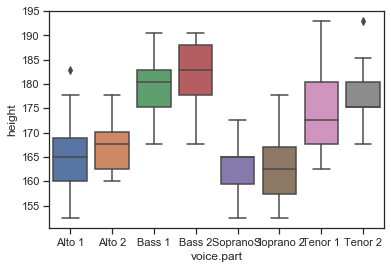

In [8]:
sns.boxplot(x='voice.part', y='height',data=singer);

Перед проверкой на равенство дисперсий и использованию ANOVA необходимо сделать проверку на нормальность.

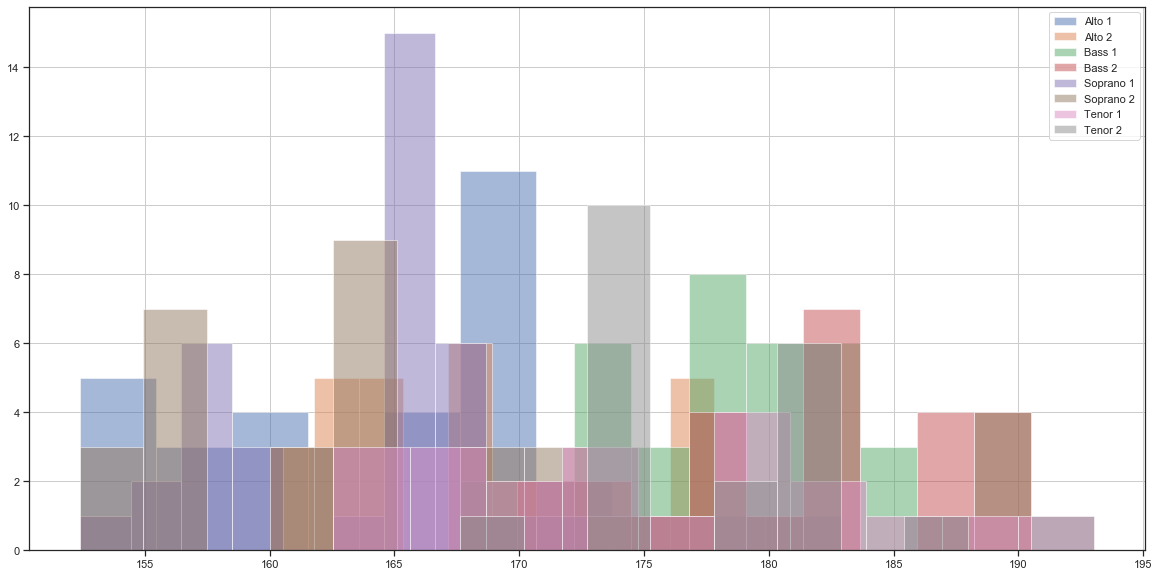

In [9]:
groups = singer.groupby("voice.part")['height']
fig, ax = plt.subplots(figsize=(20,10))

for label, group in groups:
    group.hist(label=label, alpha=0.5, ax=ax)

ax.legend();

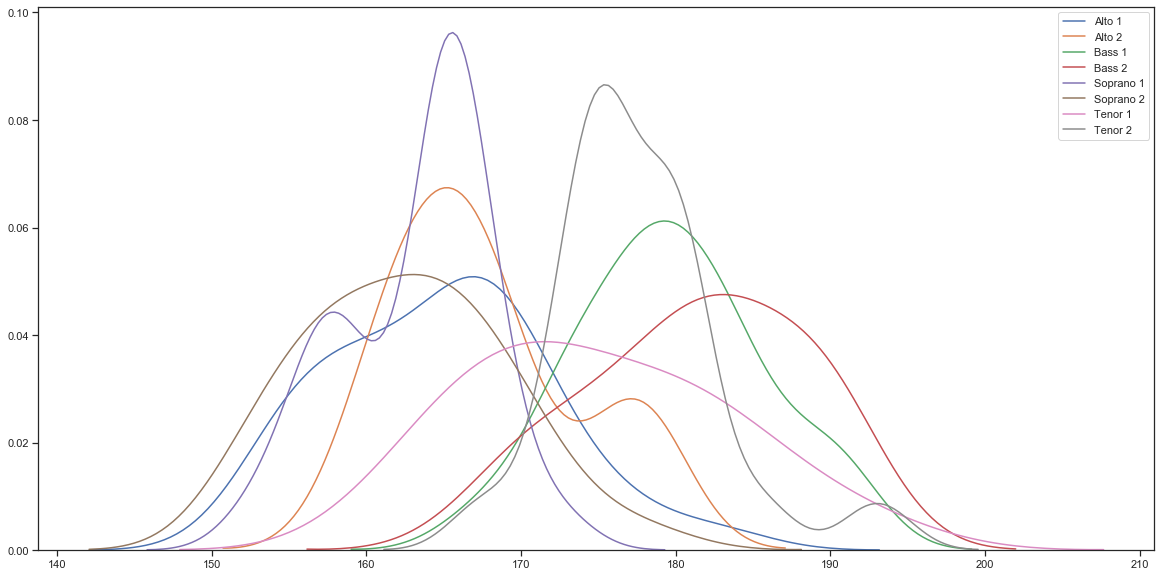

In [10]:
fig, ax = plt.subplots(figsize=(20,10))
for label, group in groups:
    sns.kdeplot(group, label = label, ax=ax)

In [11]:
pg.normality(singer, dv="height", group="voice.part", alpha=0.01)

,W,pval,normal
Soprano 1,0.901836,0.003832,False
Soprano 2,0.967122,0.463724,True
Alto 1,0.968387,0.400495,True
Alto 2,0.871288,0.003132,False
Tenor 1,0.965708,0.637467,True
Tenor 2,0.889947,0.022446,True
Bass 1,0.958989,0.164986,True
Bass 2,0.928962,0.073209,True


-----
Если данные не имеют Гаусcово распределение, то 

    1) можно воспользоваться преобразованием Бокса-Кокса:

$y(\lambda) = \begin{cases}
    (y^\lambda-1)/\lambda,& \text{if } \lambda\neq 0\\
    \log y,              & \text{if } \lambda= 0
\end{cases}$

    2) Воспользоваться критерием Краскела-Уоллиса

    3) Придумать отговорку

In [12]:
Soprano1, lmda, conf_int = stats.boxcox(singer.loc[singer['voice.part'] == 'Soprano 1'].height, alpha = 0.05) 

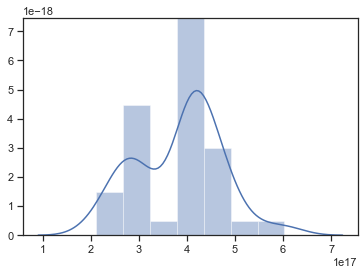

In [13]:
sns.distplot(Soprano1, hist = True, kde = True);

In [14]:
pg.kruskal(singer, dv='height', between='voice.part')

,Source,ddof1,H,p-unc
Kruskal,voice.part,7,141.836,2.095721e-27


-----
Далее необходимо проверить гипотезу о равенстве дисперсий (Бартлета) и в случае, если эта гипотеза принимается, воспользоваться нормальным однофакторным дисперсионным анализом для проверки гипотезы о равнестве всех средних.  

In [15]:
pg.homoscedasticity(singer,method='bartlett', dv='height', group='voice.part', alpha=0.05) 

,T,pval,equal_var
bartlett,11.736,0.109566,True


----
Если равенства дисперсий нет:

   1) Воспользоваться критерием Краскела-Уоллиса
    
   2) Использовать `pg.welch_anova()` (https://www.researchgate.net/publication/228898214_How_to_keep_the_Type_I_Error_Rate_in_ANOVA_if_Variances_are_Heteroscedastic)
____

In [16]:
pg.anova(dv='height', between='voice.part', data=singer, detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,voice.part,12911.304,7,1844.472,45.642,5.61705e-40,0.585
1,Within,9173.484,227,40.412,-,-,-


# Влияние витамина C на рост зубов морских свинок

В эксперименте изучалось влияние витамина C на рост одонтобластов морских свинок.  

Рассматривалось три дозы витамина (0.5, 1 и 2 мг) и два способа его приёма (апельсиновый сок и аскорбиновая кислота). В каждой из 6 групп по уровням двух факторов были произведены измерения для 10 морских свинок.

In [17]:
ToothGrowth = pd.read_csv('ToothGrowth.csv', sep=',')
ToothGrowth['dose'] = ToothGrowth['dose'].astype('category')
ToothGrowth['supp'] = ToothGrowth['supp'].astype('category')

In [18]:
ToothGrowth.head()

,len,supp,dose
0,4.2,VC,0.5
1,11.5,VC,0.5
2,7.3,VC,0.5
3,5.8,VC,0.5
4,6.4,VC,0.5


In [19]:
ToothGrowth.describe()

,len
count,60.000000
mean,18.813333
std,7.649315
min,4.200000
25%,13.075000
50%,19.250000
75%,25.275000
max,33.900000


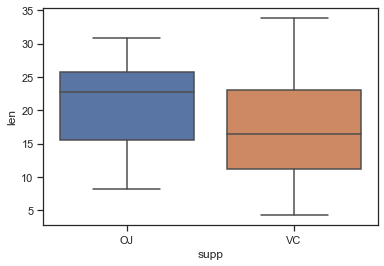

In [20]:
sns.boxplot(x='supp', y='len',data=ToothGrowth);

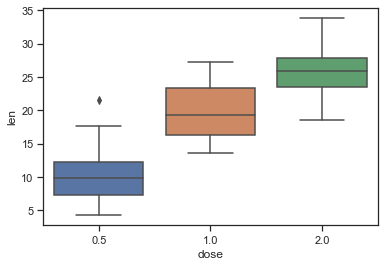

In [21]:
sns.boxplot(x='dose', y='len',data=ToothGrowth);

Применим нормальный двухфакторный дисперсионный анализ учетом межфакторного взаимодействия.

In [22]:
pg.anova(dv='len', between=['dose', 'supp'], data=ToothGrowth,detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,dose,2426.434,2,1213.217,91.999952,4.046303e-18,0.773109
1,supp,205.350,1,205.350,15.571979,2.311828e-04,0.223825
2,dose * supp,108.319,2,54.160,4.107004,2.186003e-02,0.132028
3,Residual,712.106,54,13.187,NaN,NaN,NaN


Межфакторное взаимодействие можно неплохо визуализировать для более-менее простых случаев c помощью команды interaction_plot. Получите графики зависимостей, если по оси x откладывать supp и если по оси x откладывать dose. Проинтерпретируйте полученные зависимости.

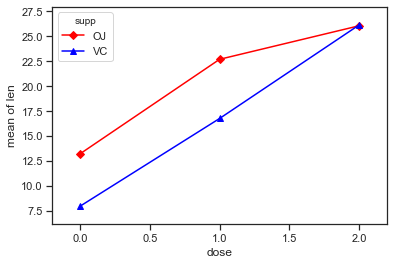

In [23]:
statsmodels.graphics.factorplots.interaction_plot(ToothGrowth['dose'], 
                                                  ToothGrowth['supp'], 
                                                  ToothGrowth['len'],
                                                  colors=['red','blue'], 
                                                  markers=['D','^'])
plt.show()

In [24]:
ToothGrowth['supp_codes'] = ToothGrowth['supp'].cat.codes

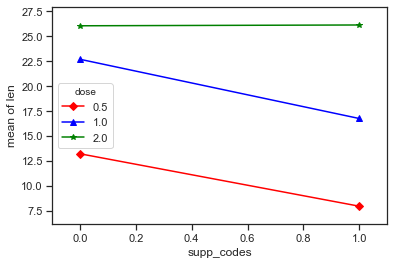

In [25]:
statsmodels.graphics.factorplots.interaction_plot(ToothGrowth['supp_codes'], 
                                                  ToothGrowth['dose'], 
                                                  ToothGrowth['len'],
                                                  colors=['red','blue', 'green'], 
                                                  markers=['D','^', '*'])
plt.show()

Взаимодействие значимо, поэтому разделим выборку по способу приёма витамина (колонка supp).

In [26]:
OJ = ToothGrowth[ToothGrowth.supp == 'OJ']
VC = ToothGrowth[ToothGrowth.supp == 'VC']

Проведите дисперсионный анализ внутри каждой из групп:  

- Для морских свинок, принимающих аскорбиновую кислоту  

- Для морских свинок, принимающих апельсиновый сок

Вам нужно  

- Построить график зависимостей len ~ dose

- Построить anova модель len ~ dose. Посмотреть на вывод summary

- Проведите тест kruskal

- Сделать выводы по для каждой из групп свинок

Для морских свинок, принимающих аскорбиновую кислоту:

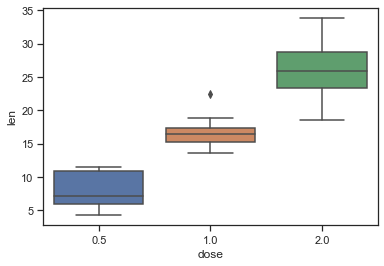

In [27]:
sns.boxplot(x='dose', y='len',data=VC)

In [28]:
pg.anova(dv='len', between=['dose'], data=VC, detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,dose,1649.489,2,824.744,67.072,3.35732e-11,0.832
1,Within,332.001,27,12.296,-,-,-


In [29]:
pg.kruskal(VC, dv='len', between='dose')

,Source,ddof1,H,p-unc
Kruskal,dose,2,25.072,0.000004


Для морских свинок, принимающих апельсиновый сок:

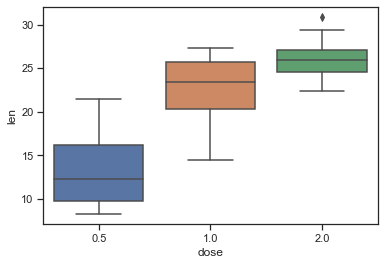

In [30]:
sns.boxplot(x='dose', y='len',data=OJ);

In [31]:
pg.anova(dv='len', between=['dose'], data=OJ, detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,dose,885.265,2,442.632,31.442,8.88716e-08,0.7
1,Within,380.105,27,14.078,-,-,-


In [32]:
pg.kruskal(OJ, dv='len', between='dose')

,Source,ddof1,H,p-unc
Kruskal,dose,2,18.506,0.000096


# Лечение гипертонии

72 пациента проходили лечение от гипертонии. Для лечения использовались три вида лекарств, при этом их эффект изучался как при использовании специальной диеты, так и в её отсутствии; кроме того, в половине случаев применялась психотерапия. Данные — артериальное давление пациента по окончании лечения.  

Требуется сравнить эффективность методов лечения гипертонии.  

In [33]:
data = pd.read_table('hyper.txt', delimiter="\t")

In [34]:
data.head()

,biofeedback,diet,drug,pressure
0,present,absent,1,170
1,present,absent,1,175
2,present,absent,1,165
3,present,absent,1,180
4,present,absent,1,160


In [35]:
data.describe()

,drug,pressure
count,72.000000,72.000000
mean,2.000000,184.500000
std,0.822226,17.838872
min,1.000000,152.000000
25%,1.000000,170.750000
50%,2.000000,182.500000
75%,3.000000,198.250000
max,3.000000,228.000000


In [36]:
data['drug'] = data['drug'].astype('category')

Проведите трехфакторный дисперсионный анализ, используя все взаимодействия ( biofeedback * diet * drug). Что можно сказать о значимости тройного взаимодействия? Можно ли интерпретировать значимость воздействия одиночных факторов в таком случае?

In [37]:
pg.anova(dv='pressure', between=['biofeedback', 'diet', 'drug'], data=data,detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,biofeedback,2048.0,1.0,2048.000,13.072,6.150719e-04,0.179
1,diet,5202.0,1.0,5202.000,33.204,3.053308e-07,0.356
2,drug,3675.0,2.0,1837.500,11.729,5.018624e-05,0.281
3,biofeedback * diet,32.0,1.0,32.000,0.204,6.529374e-01,0.003
4,biofeedback * drug,259.0,2.0,129.500,0.827,4.424565e-01,0.027
5,diet * drug,903.0,2.0,451.500,2.882,6.381527e-02,0.088
6,biofeedback * diet * drug,1075.0,2.0,537.500,3.431,3.883423e-02,0.103
7,Residual,9400.0,60.0,156.667,NaN,NaN,NaN


Нарисуйте графики взаимодействия  

- между психотерапией и использованием лекарств для каждого фиксированного значения диеты.  

- между диетой и использованием лекарства при фиксированном значении психотерапии.  

Можете ли вы проинтерпретировать данные графики?  

In [38]:
absent_diet = data[data.diet == 'absent'].reset_index()
present_diet = data[data.diet == 'present'].reset_index()

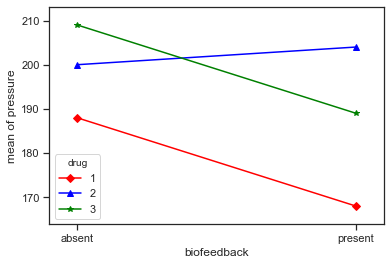

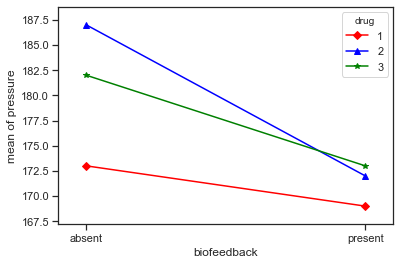

In [39]:
# diet is Absent
statsmodels.graphics.factorplots.interaction_plot(absent_diet.biofeedback, 
                                                  absent_diet.drug, 
                                                  absent_diet.pressure,
                                                  colors=['red','blue', 'green'], 
                                                  markers=['D','^', '*'])
# diet is Present
statsmodels.graphics.factorplots.interaction_plot(present_diet.biofeedback, 
                                                  present_diet.drug, 
                                                  present_diet.pressure,
                                                  colors=['red','blue', 'green'], 
                                                  markers=['D','^', '*'])
plt.show()

In [40]:
absent_biofeedback = data[data.biofeedback == 'absent'].reset_index()
present_biofeedback = data[data.biofeedback == 'present'].reset_index()

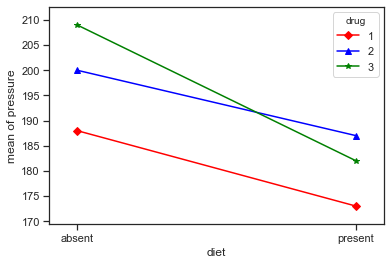

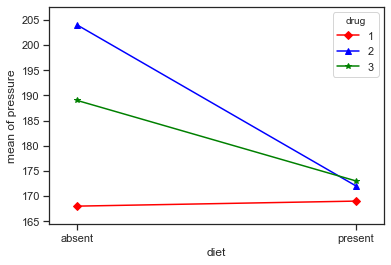

In [41]:
# biofeedback is Absent
statsmodels.graphics.factorplots.interaction_plot(absent_biofeedback.diet, 
                                                  absent_biofeedback.drug, 
                                                  absent_biofeedback.pressure,
                                                  colors=['red','blue', 'green'], 
                                                  markers=['D','^', '*'])
# biofeedback is Present
statsmodels.graphics.factorplots.interaction_plot(present_biofeedback.diet, 
                                                  present_biofeedback.drug,
                                                  present_biofeedback.pressure,
                                                  colors=['red','blue', 'green'], 
                                                  markers=['D','^', '*'])
plt.show()

Тройное взаимодействие значимо, поэтому разделим выборку по одному из признаков.  

Двухфакторный дисперсионный анализ для пациентов, проходящих психотерапию:

In [42]:
pg.anova(dv='pressure', between=['diet', 'drug'], data=present_biofeedback,detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,diet,2209.0,1,2209.000,15.248504,0.000496,0.336995
1,drug,2342.0,2,1171.000,8.083295,0.001556,0.350179
2,diet * drug,1634.0,2,817.000,5.639669,0.008334,0.273244
3,Residual,4346.0,30,144.867,NaN,NaN,NaN


Есть значимое межфакторное взаимодействие:

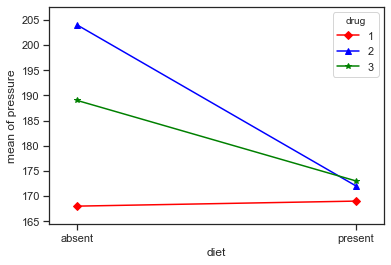

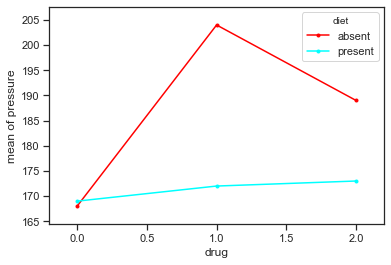

In [43]:
statsmodels.graphics.factorplots.interaction_plot(present_biofeedback.diet, 
                                                  present_biofeedback.drug,
                                                  present_biofeedback.pressure,
                                                  colors=['red','blue', 'green'], 
                                                  markers=['D','^', '*'])

statsmodels.graphics.factorplots.interaction_plot(present_biofeedback.drug, 
                                                  present_biofeedback.diet,
                                                  present_biofeedback.pressure)
plt.show()

Поэтому снова поделим выборку.  

Однофакторный анализ для пациентов, проходящих психотерапию и сидящих на диете:  

In [44]:
present_bio_present_diet = present_biofeedback[present_biofeedback.diet == 'present'].reset_index()

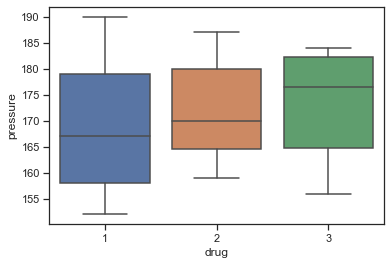

In [45]:
sns.boxplot(x='drug', y='pressure',data=present_bio_present_diet)

In [46]:
pg.anova(dv='pressure', between=['drug'], data=present_bio_present_diet,detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,drug,52.0,2,26.0,0.164,0.850126,0.021
1,Within,2376.0,15,158.4,-,-,-


Значимых различий между эффектами препаратов нет.  

Однофакторный анализ для пациентов, проходящих психотерапию и не сидящих на диете:  

In [47]:
present_bio_absent_diet = present_biofeedback[present_biofeedback.diet == 'absent'].reset_index()

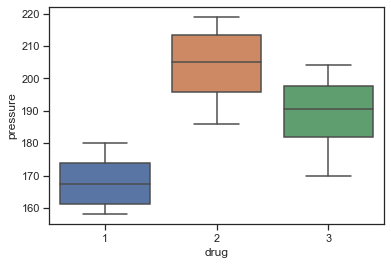

In [48]:
sns.boxplot(x='drug', y='pressure',data=present_bio_absent_diet)

In [49]:
pg.anova(dv='pressure', between=['drug'], data=present_bio_absent_diet,detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,drug,3924.0,2,1962.000,14.939,0.000269414,0.666
1,Within,1970.0,15,131.333,-,-,-


In [50]:
mc = statsmodels.stats.multicomp.MultiComparison(present_bio_absent_diet['pressure'],
                                                 present_bio_absent_diet['drug'])
mc_results = mc.tukeyhsd()
print(mc_results)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     1      2     36.0  0.001  18.8206 53.1794   True
     1      3     21.0 0.0163   3.8206 38.1794   True
     2      3    -15.0 0.0918 -32.1794  2.1794  False
-----------------------------------------------------


Препарат 1 значимо эффективнее двух других.  

Двухфакторный дисперсионный анализ для пациентов, не проходящих психотерапию: 

In [51]:
pg.anova(dv='pressure', between=['diet','drug'], data=absent_biofeedback,detailed=True)

,Source,SS,DF,MS,F,p-unc,np2
0,diet,3025.0,1,3025.000,17.956074,0.000198,0.374428
1,drug,1592.0,2,796.000,4.724970,0.016448,0.239543
2,diet * drug,344.0,2,172.000,1.020973,0.372422,0.063727
3,Residual,5054.0,30,168.467,NaN,NaN,NaN


In [52]:
pg.pairwise_tukey(data=absent_biofeedback, dv='pressure', between='drug')

,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,1,2,180.5,193.5,-13.0,6.522,two-sided,-1.993,0.117048,-0.786
1,1,3,180.5,195.5,-15.0,6.522,two-sided,-2.300,0.058436,-0.907
2,2,3,193.5,195.5,-2.0,6.522,two-sided,-0.307,0.900000,-0.121


In [54]:
pg.pairwise_tukey(data=absent_biofeedback, dv='pressure', between='diet')

,A,B,mean(A),mean(B),diff,se,tail,T,p-tukey,hedges
0,absent,present,199.0,180.667,18.333,4.779,two-sided,3.836,0.001,1.25
